[ Object Detect Model : Faster R-CNN]
- 데이터셋 : cocodataset
- 카테고리 : 배경, 개, 고양이

[1] 모듈 로딩 및 데이터 준비 <hr>

In [1]:
# [1-1] 모듈 로딩
import os
import torch

from PIL import Image
from pycocotools.coco import COCO

from torch.utils.data import Dataset

from torchvision import transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import matplotlib.patches as patches

c:\Users\knudc\anaconda3\envs\NLP\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2] 전용 데이터셋, 데이터 로더 생성 <hr>

In [2]:
# [2-1] 전용 데이터셋 클래스 정의

class COCODataset(Dataset):
    
    
    # root = coco 데이터셋의 경로
    def __init__(self,root,train,transform=None):
        super().__init__()
        directory = 'train' if train else 'val'
        # 어노테이션 파일의 존재 이유
        # - 객체 검출을 위한 학습 데이터 제공- 이미지만으로는 객체가 어디에 위치하는지, 어떤 클래스인지 알 수 없어요.
        # - 따라서 어노테이션 파일에는 객체의 바운딩 박스, 카테고리, 이미지 ID 등의 정보가 저장됨.

        # - 자동 학습 프로세스 가능- 사람이 일일이 데이터를 입력하는 대신, 모델이 파일을 읽어서 자동으로 학습할 수 있도록 함.
        # - 여러 이미지에 대한 정보를 체계적으로 저장하고 활용할 수 있게 됨.

        # - 데이터 정리 및 관리- 수천, 수만 개의 이미지에서 일관된 형식으로 정보를 저장할 수 있음.
        # - 연구나 모델 성능 비교를 할 때도 동일한 형식의 데이터를 유지하는 데 필수적.
        # annotations = annotations 디렉터리에 있는 어노테이션 Json 파일의 경로를 설정함 
        annotations = os.path.join(root, 'annotations', f'{directory}_annotations.json')
        
        self.coco = COCO(annotations)        # COCO 객체를 생성함
        self.image_path = os.path.join(root,directory)
        self.transform = transform
        
        self.categories = self._get_categories()
        self.data = self._load_data()
       
        
    def _get_categories(self):
        categories = {0:'background'}                     # 0번 배경을 새로이 추가하기 
        for category in self.coco.cats.values():          # 모든 카테고리 정보 가져오기 
            categories[category['id']] = category['name']
            
        return categories
    
    
    # 이미지와 어노테이션 정보를 불러오는 메서드 
    def _load_data(self):
    
        data = []
        
        for _id in self.coco.imgs:
            file_name = self.coco.loadImgs(_id)[0]['file_name']
            image_path = os.path.join(self.image_path, file_name)
            image = Image.open(image_path).convert("RGB")
            
            boxes = []
            labels =[]
            anns = self.coco.loadAnns(self.coco.getAnnIds(_id))
            
            for ann in anns:
                x, y, w, h = ann['bbox']
                
                boxes.append([x,y,x+w,y+h])
                labels.append(ann['category_id'])
                
            target = {'image_id':torch.LongTensor([_id]),
                    'boxes':torch.FloatTensor(boxes),
                    'labels':torch.LongTensor(labels)}
            data.append([image,target])
            
        return data
    
    
    def __getitem__(self,index):
        image,target = self.data[index]
    
        if self.transform:
            image = self.transform(image)
        
        return image, target


    def __len__(self):
        return len(self.data)

In [3]:
# [2-2] collator?

def collator(batch):
    return tuple(zip(*batch))

transform = transforms.Compose([transforms.PILToTensor(),
                                transforms.ConvertImageDtype(dtype=torch.float)])

# 데이터셋 생성
train_dataset = COCODataset('../data/coco', train=True, transform=transform)
test_dataset = COCODataset('../data/coco', train=False, transform=transform)

# 데이터로더 생성 
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=True, collate_fn=collator)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, drop_last=True, collate_fn=collator)

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [4]:
# 클래스 변환 Dict 생성
IDX_TO_CATEGORY = train_dataset.categories
IDX_TO_CATEGORY 

{0: 'background', 1: 'cat', 2: 'dog'}

In [5]:
# 학습용 테스트용 데이터 확인
print(f'[trainDS 갯수] : {len(train_dataset)}개')
print(f'[testDS 갯수] : {len(test_dataset)}개')

[trainDS 갯수] : 2431개
[testDS 갯수] : 181개


In [6]:
# 학습용 데이터셋에서 이미지 1개 출력해보기
imgTS, targetDict = train_dataset[68]       # __getitem__(idx) 메서드 적용 결과
print(imgTS.shape, targetDict.keys())

torch.Size([3, 429, 640]) dict_keys(['image_id', 'boxes', 'labels'])


In [7]:
# 라벨 정보 추출
label = targetDict['labels'].item()

In [8]:
# 객체 위치 정보 추출 : 객체영역 좌표 점
lx, ly, rx, ry = [round(data.item()) for data in targetDict['boxes'].reshape(-1)]  # 2차원 텐서(실수) -> 1차원 (정수)
w, h = rx-lx, ry-ly

print(f'lx,ly,w,h => {lx,ly,w,h}')

lx,ly,w,h => (363, 172, 82, 78)


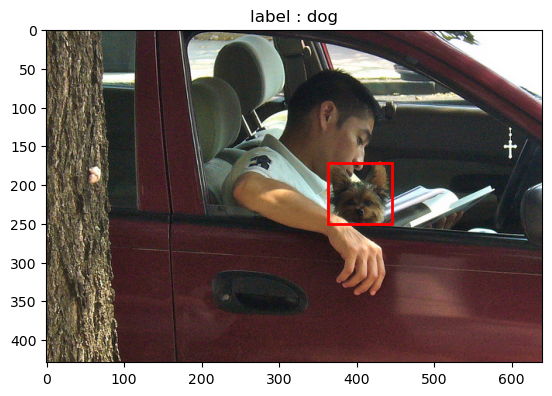

In [9]:
# 시각화 및 바운딩 박스 확인 
plt.imshow(imgTS.permute(1,2,0))
plt.title(f'label : {IDX_TO_CATEGORY[label]}')

# 바운딩 박스 추가
ax = plt.gca()   # get current axis
ax.add_patch(patches.Rectangle((lx,ly),w,h, color='red', linewidth=2, fill=False))
plt.show()

[3] 모델 정의 및 설계 <hr>
- 모델 네트워크 구성
   * Backbone Network : VGG16        # 입력 데이터에서 특징 추출 후 최종 분류기에 전달하는 딥러닝 모델 
   * Neck Network : RPN              # 객체의 위치를 찾기 위한 후보 영역을 생성 
   * Head Network : Faster R-CNN     # RPN이 생성한 영역을 바탕으로 객체를 최종 분류하고 위치를 조정함 

In [10]:
from torchvision.models import vgg16, VGG16_Weights
from torchvision.models.detection import rpn, FasterRCNN
from torchvision import ops
from torchvision import models 

In [11]:
# 백본 및 모델 구조 정의
backbone = models.vgg16(weights = 'VGG16_Weights.IMAGENET1K_V1').features
backbone.out_channels = 512

anchor_generator = rpn.AnchorGenerator(sizes=((32,64,128,256,512),),
                                       aspect_ratios = ((0.5,1.0,2.0),))

roi_pooler = ops.MultiScaleRoIAlign(featmap_names=["0"],
                                    output_size=(7,7),
                                    sampling_ratio=2)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = FasterRCNN(backbone=backbone,
                   num_classes=3,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler).to(device)

In [12]:
# 최적화 함수 및 학습률 스케쥴러
from torch import optim

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [13]:
# Faster R-CNN 미세 조정
for epoch in range(5):
    cost = 0.0
    for idx, (images,targets) in enumerate(train_dataloader):
        images = list(image.to(device) for image in images)
        targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        cost += losses
        
    lr_scheduler.step()
    cost = cost / len(train_dataloader)
    print(f'Epoch : {epoch+1:4d}, Cost : {cost:.3f}')

KeyboardInterrupt: 

In [ ]:
# 모델 추론 및 시각화
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from torchvision.transforms.functional import to_pil_image


def draw_bbox(ax, box, text, color):
    ax.add_patch(
        plt.Rectangle(xy=(box[0],box[1]),
                      width=box[2]-box[0],
                      height=box[3]-box[1],
                      fill=False,
                      edgecolor=color,
                      linewidth=2))
    
    ax.annotate(text=text,
                xy=(box[0]-5, box[1]-5),
                color=color,
                weight='bold',
                fontsize=13)
    
    
threshold = 0.5
categories = test_dataset.categories
with torch.no_grad():
    model.eval()
    for images, targets in test_dataloader:
        images = [image.to(device) for image in images]
        outputs = model(images)
        
        boxes = outputs[0]['boxes'].to('cpu').numpy()
        labels = outputs[0]['labels'].to('cpu').numpy()
        scores = outputs[0]['scores'].to('cpu').numpy()
        
        boxes = boxes[score >= threshold].astype(np.int32)
        labels = labels[score >= threshold]
        scores = scores[score >= threshold]
        
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(1,1,1)
        plt.imshow(to_pil_image(images[0]))
        
        for box, label, score in zip(boxes, labels, scores):
            draw_bbox(ax,box,f'{categories[label]} - {score:.4f}', 'red')
            
        tboxes = targets[0]['boxes'].numpy()
        tlabels = targets[0]['labels'].numpy()
        for box, label in zip(tboxes,tlabels):
            draw_bbox(ax,box,f'{categories[label]}', "blue")
            
        plt.show()

In [ ]:
# 모델 평가
import numpy as np
from pycocotools.cocoeval import COCOeval

with torch.no_grad():
    model.eval()
    coco_detections = []
    
    for images, targets in test_dataloader:
        images = [img.to(device) for img in images]
        outputs = model(images)
        
        for i in range(len(targets)):
            image_id = targets[i]['image_id'].data.cpu().numpy().tolist()[0]
            boxes = outputs[i]['boxes'].data.cpu().numpy()
            boxes[:,2] = boxes[:,2] - boxes[:,0]
            boxes[:,3] = boxes[:,3] - boxes[:,1]
            scores = outputs[i]['scores'].data.cpu().numpy()
            labels = outputs[i]['labels'].data.cpu().numpy()
            
            for instance_id in range(len(boxes)):
                box = boxes[instance_id,:].tolist()
                prediction = np.array([image_id,
                                       box[0],
                                       box[1],
                                       box[2],
                                       box[3],
                                       float(scores[instance_id]),
                                       int(labels[instance_id])])
                coco_detections.append(prediction)
                
    coco_detections = np.asarray(coco_detections)
    coco_gt = test_dataloader.dataset.coco
    coco_dt = coco_gt.loadRes(coco_detections)
    coco_evaluator = COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_evaluator.evaluate() 
    coco_evaluator.accumulate()
    coco_evaluator.summarize()                    